Check Python version

In [432]:
!python --version

Python 3.10.14


Import libraries

In [433]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [434]:
# Through online GitHub
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [435]:
train_df = pd.read_csv(file_name)

In [436]:
train_df.shape

(144, 2)

In [437]:
train_df.columns

Index(['ds', 'y'], dtype='object')

In [438]:
train_df.head()

ds    y
0  1949-01-01  112
1  1949-02-01  118
2  1949-03-01  132
3  1949-04-01  129
4  1949-05-01  121

In [439]:
train_df.tail()

ds    y
139  1960-08-01  606
140  1960-09-01  508
141  1960-10-01  461
142  1960-11-01  390
143  1960-12-01  432

Define the required time and target columns

In [440]:
time_col = train_df.columns[0]
target_col = train_df.columns[-1]
train_df[time_col] = train_df[time_col].astype(str)

Change target column to float

In [441]:
train_df[target_col] = train_df[target_col].astype(float)

In [442]:
train_df.head()

ds      y
0  1949-01-01  112.0
1  1949-02-01  118.0
2  1949-03-01  132.0
3  1949-04-01  129.0
4  1949-05-01  121.0

Plot graph

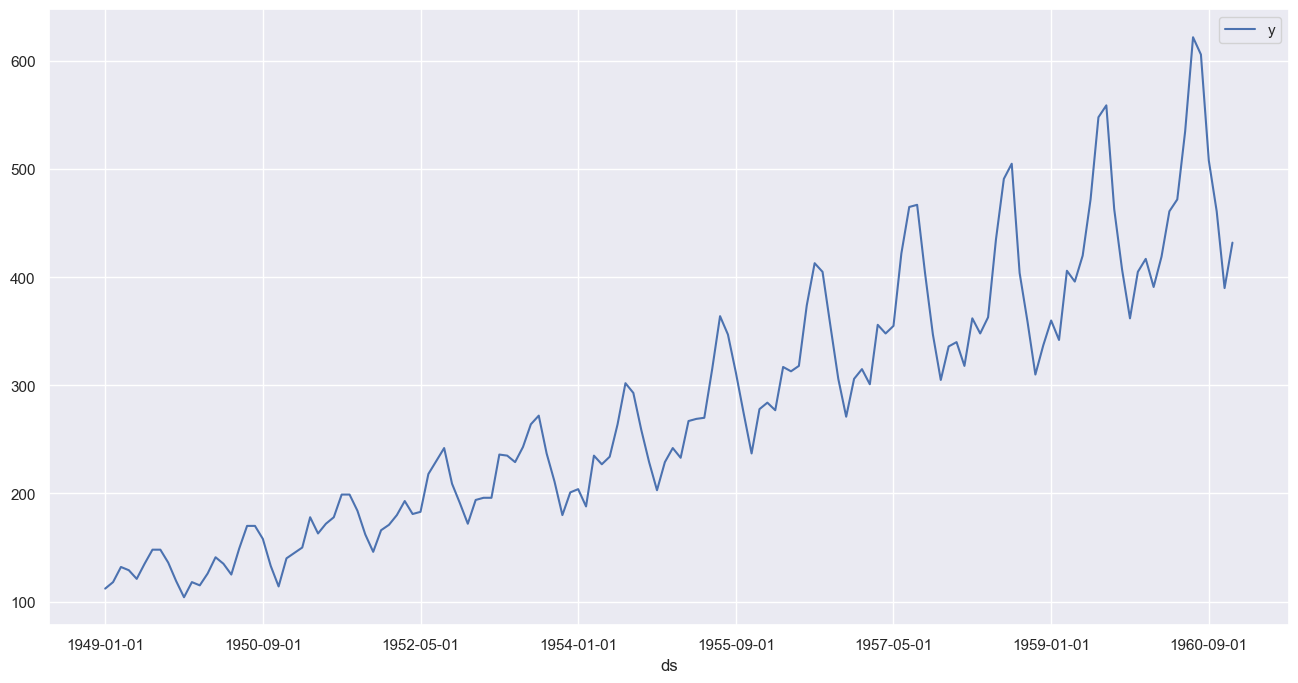

In [443]:
figsize = (16, 8)
train_df.set_index(time_col).plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [444]:
train_data = []

In [445]:
for value in train_df.values:
    train_data.append(list(value))

In [446]:
train_data[:10]

[['1949-01-01', 112.0],
 ['1949-02-01', 118.0],
 ['1949-03-01', 132.0],
 ['1949-04-01', 129.0],
 ['1949-05-01', 121.0],
 ['1949-06-01', 135.0],
 ['1949-07-01', 148.0],
 ['1949-08-01', 148.0],
 ['1949-09-01', 136.0],
 ['1949-10-01', 119.0]]

Define Model Request (optional)

In [447]:
# Default model request
# model_request = {
#     'type': 'meta_lr',
#     'scorers': ['smape', 'mase'],
#     'params': {
#         'preprocessors': [
#             {'type': 'dartsimputer'},
#             {'type': 'minmaxscaler'},
#         ],
#         'base_models': [
#             {'type': 'darts_naive'},
#             {'type': 'darts_seasonalnaive'},
#             {'type': 'darts_autotheta'},
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autoets'},
#         ],
#     },
# }

# Onboard NeuralProphet customized model request
# np_external_model_request = {
#     'params': {
#       'changepoints_range': 0.2,
#       'epochs': 2,
#       'growth': 'off'
#     },
#     'metrics': [],
#     'type': 'neuralprophet',
# }
np_external_model_request = None

# Customized model request
model_request = {
    'type': 'meta_wa',  # 'meta_naive', 'meta_wa'
    'scorers': ['mase', 'smape'],
    'params': {
        'preprocessors': [
            {'type': 'dartsimputer'},
            {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            # {'type': 'darts_naive'},
            # {'type': 'darts_seasonalnaive'},
            # {'type': 'darts_autotheta'},
            # {'type': 'stats_autotheta'},
            # {'type': 'darts_autoets'},
            # {'type': 'stats_autoets'},
            # {'type': 'darts_autoarima'},
            # {'type': 'stats_autoarima'},
            # {'type': 'darts_autoces'},
            # {'type': 'darts_kalman'},
            # {'type': 'darts_catboost'},            
            # # {'type': 'darts_tbats'},
            # # {'type': 'darts_linearregression'},
            # {'type': 'darts_lightgbm',
            #  'params': {
            #      'lags': 12,
            #      'output_chunk_length': 6,
            #      'verbose': -1
            # }}
            {'type': 'neuralprophet',
             'external_params': np_external_model_request
            }  # Onboard NeuralProphet external service
        ],
    },
}

This is for JSON model_request

In [448]:
# file_path = 'model_request.json'
# # For writing the model request to a json file
# with open(file_path, 'r') as file:
#     model_request = json.load(file)

This is for YAML model_request

In [449]:
file_path = 'model_request.yaml'
# For reading the model request from a yaml file
with open(file_path, 'r') as file:
    model_request = yaml.safe_load(file)

print(model_request)

{'type': 'meta_wa', 'scorers': ['mase', 'smape'], 'params': {'preprocessors': [{'type': 'dartsimputer'}, {'type': 'minmaxscaler'}], 'base_models': [{'type': 'deepsybil', 'external_params': {'type': 'meta_wa', 'scorers': ['mase', 'smape'], 'params': {'preprocessors': [{'type': 'minmaxscaler'}], 'base_models': [{'type': 'darts_tsmixer'}, {'type': 'darts_tide'}]}}}]}}


Train API JSON Payload

In [450]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [451]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [452]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [453]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [454]:
# %%time
# print("Hello")
response = requests.post(url, json=api_json)
# print(response)
# print()

In [455]:
train_json_out = response.json()  # dict output
train_json_out

{'model': 'AgEBCAJeQwAAABAAb1pDAEpeEwBqXiMAc10zACpeAwAkAAAAAl4DAExLTldWUVZOVE9NVU9XTVNjTmJPWk5XUVJkY1JUWmNSZE5aWmVjUUtjZU1PU2RTUlVSZFlTVFFkY2NOUlRVZU1RZFRlVFpVYVNVUWJPTlZhU09WUk5VVVZSTmVaTmFaUlZSVU5PVFplZFlhTk5UY01WZFRaVE5UT1JZS0tOTlRaZGFVYmNMU2FSTVNhS2FTUmNhYmVTZWJhYVRlTU1iVVJiYkxUV1dTUlFaY1lWU1pTV1RRS1pXTmJZUWVVU1JhUmJVTU5RWldOZWFlTWRWYmRjZU9kVWRjWU5TT2VRVmJZU01UWVNaUmJOYk1OVlVSV1JjZGFLTmFjZFRTZWJPZGVXUlNjZUxiVVJkY1NaY01TWVRhWmVhZGVVU1JRTktXVllaYVVTUldTS1lVV2JNVVNTU01lY1NiU1JOTU5lTVNiYmVXZFpPVFNaVFVWTlZRU1ROVmFSY05TU2VWZFNZV1VSWlJhUmRkVWVjVVNiYlllUU5ZWmVWUUxTUU5jY2NRVldSWi9RWU9RUUhkZVFaUVFWTlFRSFFUUWRUUVRhZFFRUVFTU1FkY1FRRVFXUVRRUlEvSFRSUWRRZE1RSFFkUVJRVVNkYmRnUVFRUlFRVWRaWVFRUVFLUVRZU1VRUVNRQ1IvUVJUUVRUUVFSZ1FRUWFUUUNRU1FRVWFRVWZRVGVRUVFZUVFRYlVRUlNUQ1FZUVFRUVVOUVlEZVFQV1RRdlEvUVFZUlVRTFFRU1VaRlFkUVZTU1ZRZEFRR2VUUlFSWlFTVFRRWllRYzRRZFFhUlRRZFlVVVFRZFFaTmRIUVpRVFVaRFdRQlNSU0JkVWFkU1pTOVFwUVRZZ1JiWVRiTGRVUVFRUUlRUUFUU09ZVVlaWWRSVFN2UUtRVXZRUVFVTlJiUVFRU1RZWVlaT1VQUVVWU1NRTlVkUVVSVEFRU

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [456]:
dates = [
    '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01', '1961-06-01',
    '1961-07-01', '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
    '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01', '1962-06-01',
    '1962-07-01', '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01',
]

Model from Train API

In [457]:
model = train_json_out['model']

Forecast API JSON Payload

In [458]:
api_json = {
    'model': model,
    'data': dates
}

Build URL (same as train except for the endpoint)

In [459]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [460]:
%%time
response = requests.post(url, json=api_json,verify=False)
print(response)
print()

<Response [200]>

CPU times: total: 15.6 ms
Wall time: 4.32 s


In [461]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['1961-01-01', 440.27400255588515],
  ['1961-02-01', 442.7775798449276],
  ['1961-03-01', 464.99835798847],
  ['1961-04-01', 483.68395237006905],
  ['1961-05-01', 527.479128770763],
  ['1961-06-01', 584.4849905452077],
  ['1961-07-01', 681.3428138009921],
  ['1961-08-01', 670.3313825883982],
  ['1961-09-01', 594.9385923009503],
  ['1961-10-01', 510.6997127499937],
  ['1961-11-01', 461.261632189466],
  ['1961-12-01', 471.0704266527666],
  ['1962-01-01', 485.4640977424199],
  ['1962-02-01', 499.99907308816887],
  ['1962-03-01', 511.33829851127064],
  ['1962-04-01', 528.2757375844768],
  ['1962-05-01', 585.3307734224338],
  ['1962-06-01', 619.9993607755501],
  ['1962-07-01', 732.8452812122894],
  ['1962-08-01', 757.476021822534],
  ['1962-09-01', 685.799637082393],
  ['1962-10-01', 578.0622339777468],
  ['1962-11-01', 527.0776094415762],
  ['1962-12-01', 522.5744326439194]]}

Combine forecast dates and output

In [462]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [463]:
forecast_df.shape

(24, 2)

In [464]:
forecast_df.columns

Index(['ds', 'y'], dtype='object')

In [465]:
forecast_df.head()

ds           y
0  1961-01-01  440.274003
1  1961-02-01  442.777580
2  1961-03-01  464.998358
3  1961-04-01  483.683952
4  1961-05-01  527.479129

In [466]:
forecast_df.tail()

ds           y
19  1962-08-01  757.476022
20  1962-09-01  685.799637
21  1962-10-01  578.062234
22  1962-11-01  527.077609
23  1962-12-01  522.574433

Plot train and forecast side-by-side

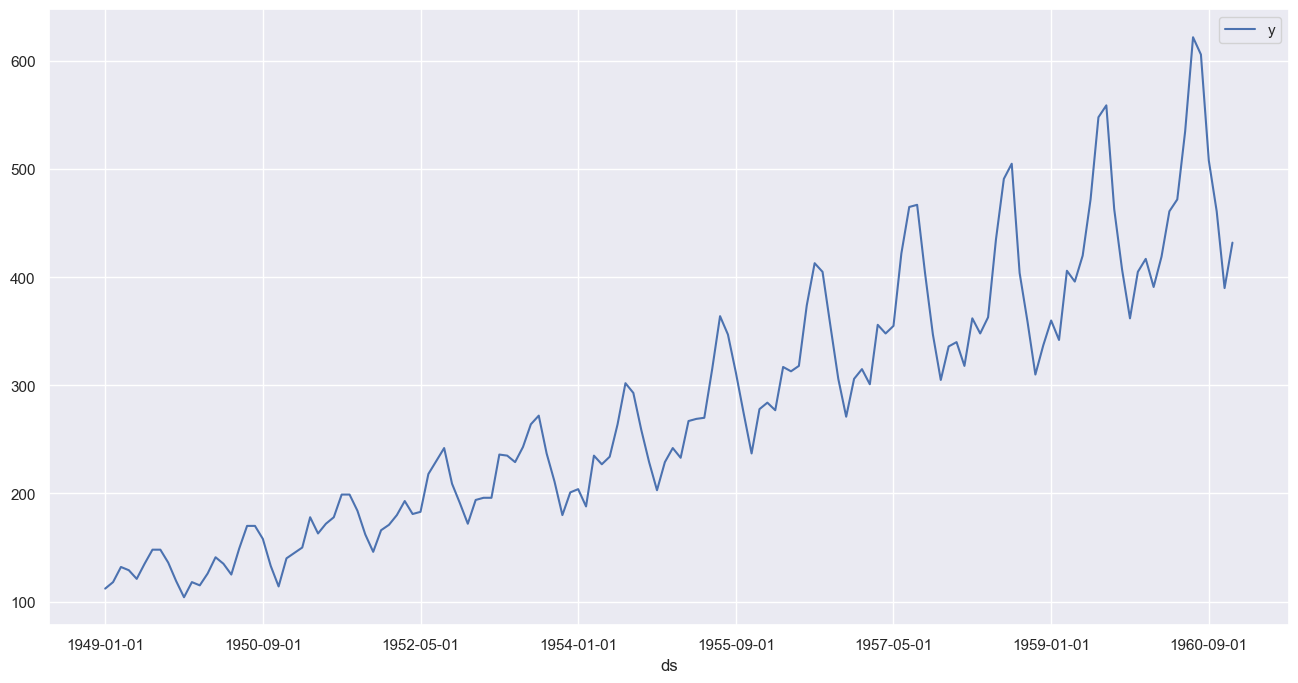

In [467]:
train_df['color'] = 'b'
train_df.set_index(time_col).plot(figsize=figsize, color=train_df['color']);

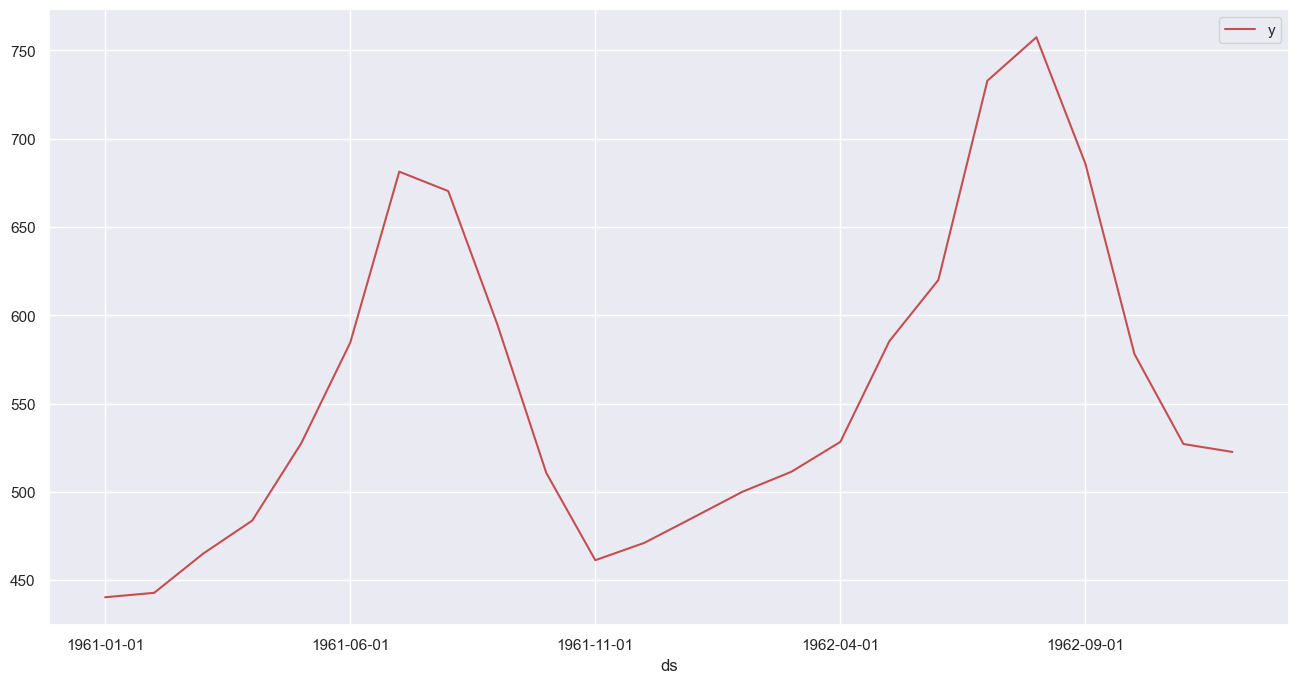

In [468]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and forecast sets

In [469]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [470]:
df.shape

(168, 3)

In [471]:
df.head()

ds      y color
0  1949-01-01  112.0     b
1  1949-02-01  118.0     b
2  1949-03-01  132.0     b
3  1949-04-01  129.0     b
4  1949-05-01  121.0     b

In [472]:
df.tail()

ds           y color
163  1962-08-01  757.476022     r
164  1962-09-01  685.799637     r
165  1962-10-01  578.062234     r
166  1962-11-01  527.077609     r
167  1962-12-01  522.574433     r

Plot combined train and forecast sets with the vertical black line as the cut-off

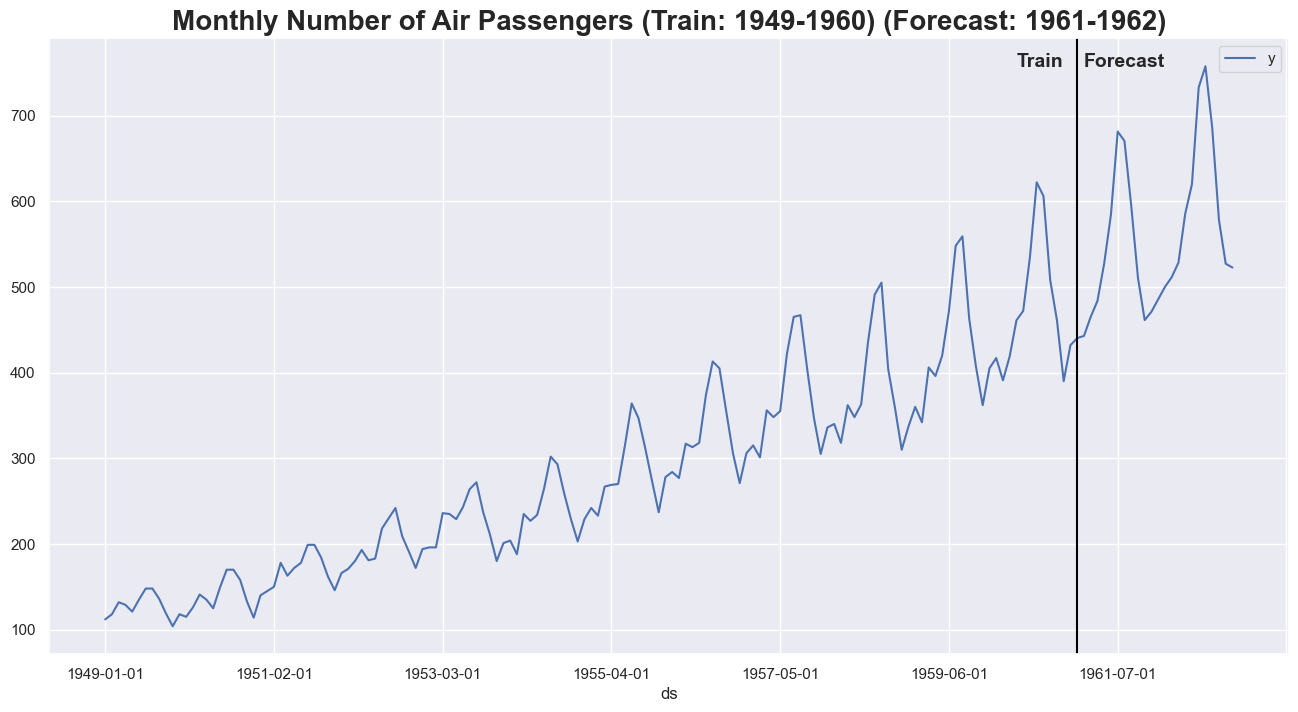

In [473]:
df.set_index(time_col).plot(figsize=figsize, color=df['color'])
plt.axvline(x=len(train_df), color='black', label='Train/Forecast set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Forecast', fontweight='bold', fontsize=14)
plt.title(label='Monthly Number of Air Passengers (Train: 1949-1960) (Forecast: 1961-1962)', fontweight='bold', fontsize=20)
plt.show();